In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
import scipy
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.optimize import minimize
import math
from scipy.optimize import Bounds
from scipy.stats import poisson
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import pacf
import matplotlib.dates as mdates
# import mpl_scatter_density # adds projection='scatter_density'


Load data

In [2]:
data_dir = os.path.join("data", "EnergyUsageAll.csv")
energy_data = pd.read_csv(data_dir)
energy_data[['Time','Zone']]= energy_data['ts'].str.split(' ', n=1, expand=True)
energy_data = energy_data.set_index('Time')
energy_data.index = pd.to_datetime(energy_data.index, format='mixed')

C:\Users\fenya\AppData\Local\Temp\ipykernel_16988\1208847523.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  energy_data.index = pd.to_datetime(energy_data.index, format='mixed')


In [3]:
data_dir = os.path.join("data", "WeatherHistorical.csv")
weather_data = pd.read_csv(data_dir)
weather_data[['Time','Zone']]= weather_data['Timestamp'].str.split(' ', n=1, expand=True)
weather_data = weather_data.set_index('Time')
weather_data.index = pd.to_datetime(weather_data.index, format='mixed')

col = 'Ithaca, NY, United States Humidity'
weather_data[col] = (weather_data[col] - weather_data[col].mean())/weather_data[col].std()

col = 'Ithaca, NY, United States Temp'
weather_data[col] = (weather_data[col] - weather_data[col].mean())/weather_data[col].std()

C:\Users\fenya\AppData\Local\Temp\ipykernel_16988\4084514803.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  weather_data.index = pd.to_datetime(weather_data.index, format='mixed')


In [4]:
weather_data = weather_data.drop(weather_data.index.difference(energy_data.index))
energy_data = energy_data.drop(energy_data.index.difference(weather_data.index))

In [5]:
energy_data = energy_data.drop(['ts','Zone'], axis=1)


In [6]:
energy_data.index[4].hour

4

In [7]:
y = energy_data.to_numpy().reshape(-1, 1)
nan_data = (np.isnan(y))
y =y[~nan_data].reshape(-1, 1)  

humid = np.repeat(weather_data.iloc[:,[2]], energy_data.shape[1]).reshape(-1, 1)[~nan_data].reshape(-1, 1)  
temp = np.repeat(weather_data.iloc[:,[4]], energy_data.shape[1]).reshape(-1, 1)[~nan_data].reshape(-1, 1)  
# sites = np.tile(df.columns, df.shape[0])

# x_lat =x_lat.reshape(-1, 1)[~nan_data].reshape(-1, 1)
# x_lon =x_lon.reshape(-1, 1)[~nan_data].reshape(-1, 1)

In [8]:
# dates = energy_data.index
dates = np.repeat(energy_data.index, energy_data.shape[1])
months = np.zeros(len(dates))
hours = np.zeros(len(dates))
# len(dates)
# Store months for stratification 
for i in range(dates.shape[0]):
    ts = pd.Timestamp(dates[i])
    months[i]=ts.month

hours = np.zeros(dates.shape[0])
for i in range(dates.shape[0]):
    ts = pd.Timestamp(dates[i])
    hours[i]=ts.hour


months = months.reshape(-1, 1)[~nan_data].reshape(-1, 1)  
hours = hours.reshape(-1, 1)[~nan_data].reshape(-1, 1)  

In [9]:
X = np.concatenate((humid, temp), axis=1)

In [10]:
def electricity_linear_model(params, X):
    μ =  params[0] + X[:,0]* params[1] + X[:,1]* params[2]
    return μ

<Axes: >

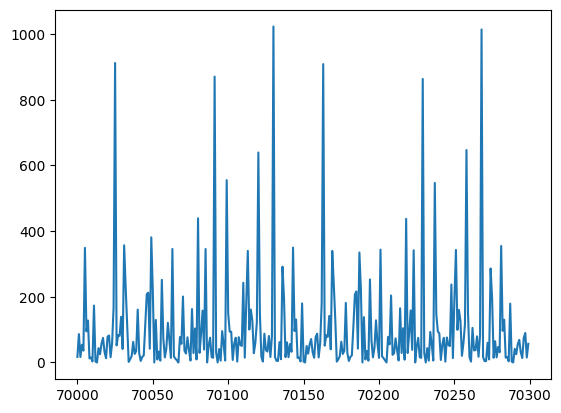

In [11]:
pd.Series(y.reshape(-1,))[70000:70300].plot()

In [15]:
def electricity_demand_model(params, X, y):
    σ = params[-1]
    μ = electricity_linear_model(params, X)
    ll = np.sum(norm.logpdf(pd.Series(y.reshape(-1,)), μ, scale=σ))  # compute log-likelihood
    return ll

In [16]:
lb = [-1000000.0, -1000000.0, -1000000.0, -1000000.0]
ub = [1000000.0, 1000000.0, 1000000.0, 1000000.0]
init = [0.5, 0.5, 0.5, 0.5]

result = minimize(lambda θ: -electricity_demand_model(θ, X, y), init, bounds=list(zip(lb, ub)))
θ_mle = result.x

In [17]:
# plt.plot(y)
# electricity_linear_model(θ_mle, X).plot()

In [18]:
θ_mle

array([116.86211839,  -5.4695709 ,   0.31104685, 172.68448242])

With AR(1) residuals

In [20]:
def electricity_linear_model(params, X):
    μ =  params[0] + X[:,0]* params[1] + X[:,1]* params[2]
    return μ

In [21]:
def elec_loglik(params, X, y):
    ρ = params[-1]
    σ = params[-2]
    elec_sim = electricity_linear_model(params, X)
    residuals = (y - elec_sim).values
    # ll = np.sum(norm.logpdf(gmsl_data, loc=y, scale=np.sqrt(σ**2+gmsl_error**2)))  # compute log-likelihood
    T = len(y)
    ll = 0  # initialize log-likelihood counter
    for t in range(len(elec_sim)):
        if t == 0:
            ll += norm.logpdf(residuals[0], loc=0, scale=np.sqrt(σ**2 / (1 - ρ**2)))
        else:
            resid_wn = residuals[t] - ρ * residuals[t-1]
            ll += norm.logpdf(resid_wn, loc=0, scale=np.sqrt(σ**2))

    return ll

In [22]:
lb = [-1000.0, -1000.0, -1000.0, 0, -0.99]
ub = [1000.0, 1000.0, 1000.0, 1000.0, 0.99]
init = [0.5, 0.5, 0.5, 0.1, 0.1]

result = minimize(lambda θ: -elec_loglik(θ, X, y), init, bounds=list(zip(lb, ub)))
θ_mle = result.x

MemoryError: Unable to allocate 11.5 TiB for an array with shape (1257902, 1257902) and data type float64


references 


https://stackoverflow.com/questions/71270630/how-to-show-only-the-monthly-ticks-in-the-x-axis-when-using-dataframe-plot